### Data Ingestion

In [18]:
# Import the needed Libraries for the project.
import pandas as pd # Main libray for loading and manipulating data tables (CSV files).
import numpy as np # Will provide us fast mathematical operations and array handaling.
import matplotlib.pyplot as plt # Will create us basic graphs and charts for visualizations.
import seaborn as sns # This will add a more proessional look to the data. 
from datetime import datetime, timedelta # Handlas the calcualtions needed for the 7 day adoption window.
from sklearn.model_selection import train_test_split #This will split the data into training and testing sets for model evaluation
from sklearn.ensemble import RandomForestClassifier #This is ML(Machine Learning ) model that  finds complex patterns in data.
from sklearn.linear_model import LogisticRegression # Simpler, more interpretable prediction model for comparison
from sklearn.metrics import classification_report, roc_auc_score  #Measures how accurate our predictions are
from sklearn.preprocessing import LabelEncoder #Converts text categories into numbers that models can understand
import warnings #Allows us to hide non-critical warning messages that clutter output
warnings.filterwarnings('ignore')



# How to read the data files in Python 

users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

# Basic data exploration
print("=== DATASET OVERVIEW ===")
print(f"Users dataset shape: {users.shape}")
print(f"User engagement dataset shape: {user_engagement.shape}")

print("\n=== USERS DATASET ===")
print("Columns:", users.columns.tolist())
print("\nFirst few rows:")
print(users.head())

print("\n=== USER ENGAGEMENT DATASET ===")
print("Columns:", user_engagement.columns.tolist())
print("\nFirst few rows:")
print(user_engagement.head())

# Check for missing values
print("\n=== DATA QUALITY CHECK ===")
print("Users dataset missing values:")
print(users.isnull().sum())

print("\nUser engagement dataset missing values:")
print(user_engagement.isnull().sum())

# Basic statistics
print(f"\n=== BASIC STATISTICS ===")
print(f"Unique users in users table: {users['object_id'].nunique():,}")
print(f"Unique users in engagement table: {user_engagement['user_id'].nunique():,}")
print(f"Total engagement records: {len(user_engagement):,}")

# Convert timestamp and show date range
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
print(f"Date range in engagement data: {user_engagement['time_stamp'].min().date()} to {user_engagement['time_stamp'].max().date()}")

# Show creation_source distribution
print(f"\n=== USER CREATION SOURCES ===")
print(users['creation_source'].value_counts())

print("\nData ingestion complete! ✓")


=== DATASET OVERVIEW ===
Users dataset shape: (12000, 11)
User engagement dataset shape: (207917, 3)

=== USERS DATASET ===
Columns: ['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'email_domain']

First few rows:
   object_id  creation_time               name                       email  \
0          1   4/22/14 3:53     Clausen August    AugustCClausen@yahoo.com   
1          2  11/15/13 3:45      Poole Matthew      MatthewPoole@gustr.com   
2          3  3/19/13 23:14  Bottrill Mitchell  MitchellBottrill@gustr.com   
3          4   5/21/13 8:09    Clausen Nicklas   NicklasSClausen@yahoo.com   
4          5  1/17/13 10:14          Raw Grace          GraceRaw@yahoo.com   

  creation_source  last_session_creation_time  opted_in_to_mailing_list  \
0    GUEST_INVITE                1.398139e+09                         1   
1      ORG_INVITE           

### 1) Calculating Adoption Rate

In [19]:
from datetime import timedelta
def calculate_user_adoption(user_id, engagement_data):
    """
    We want to calculate if the user is adopted based on the following reuirement:
    'logged into the product on three separate days in at least one seven-day period.'
    """
    # Get all the unquie logindates from this indiviaual user
    user_logins = engagement_data[engagement_data['user_id'] == user_id]['time_stamp'].dt.date.unique()
    user_logins = sorted(user_logins)

    # Sliding 7 day window login check
    for i in range(len(user_logins)):
            start_date = user_logins[i]
            end_date = start_date + timedelta(days=6)
            login_days_in_window = sum(1 for date in user_logins if start_date <= date <= end_date)
            if login_days_in_window >= 3:
                return True
    return False

In [20]:
users_with_engagement = user_engagement['user_id'].unique()

print("=== ADOPTION CALCULATION OVERVIEW ===")
print(f"Total users in users table: {len(users):,}")
print(f"Users with engagement data: {len(users_with_engagement):,}")
print(f"Users with no engagement data: {len(users) - len(users_with_engagement):,}")


=== ADOPTION CALCULATION OVERVIEW ===
Total users in users table: 12,000
Users with engagement data: 8,823
Users with no engagement data: 3,177


In [21]:
print(f"\nCalculating adoption for {len(users_with_engagement):,} users...")

adoption_results = []
for user_id in users_with_engagement:
    is_adopted = calculate_user_adoption(user_id, user_engagement)
    adoption_results.append({'user_id': user_id, 'is_adopted': is_adopted})

adoption_df = pd.DataFrame(adoption_results)



Calculating adoption for 8,823 users...


In [22]:
users_with_adoption = users.merge(adoption_df, left_on='object_id', right_on='user_id', how='left')
users_with_adoption['is_adopted'] = users_with_adoption['is_adopted'].fillna(False)

total_users = len(users_with_adoption)
adopted_users = users_with_adoption['is_adopted'].sum()
users_with_no_engagement = users_with_adoption['user_id'].isna().sum()

overall_adoption_rate = adopted_users / total_users
engaged_adoption_rate = adopted_users / len(users_with_engagement)

print("\n=== FINAL ADOPTION RATE RESULTS ===")
print(f"Total users: {total_users:,}")
print(f"Adopted users: {int(adopted_users):,}")
print(f"Users with no engagement: {users_with_no_engagement:,}")
print(f"Overall adoption rate: {overall_adoption_rate:.1%}")
print(f"Adoption rate among engaged users: {engaged_adoption_rate:.1%}")

print("\n=== SAMPLE ANALYSIS ===")
adopted_sample = users_with_adoption[users_with_adoption['is_adopted']].head(3)
not_adopted_sample = users_with_adoption[~users_with_adoption['is_adopted']].head(3)

print("Sample of adopted users:")
for _, user in adopted_sample.iterrows():
    user_engagement_count = len(user_engagement[user_engagement['user_id'] == user['object_id']])
    print(f"  User {user['object_id']}: {user_engagement_count} total logins, Creation source: {user['creation_source']}")

print("\nSample of non-adopted users:")
for _, user in not_adopted_sample.iterrows():
    if pd.notna(user['user_id']):
        count = len(user_engagement[user_engagement['user_id'] == user['object_id']])
        print(f"  User {user['object_id']}: {count} total logins, Creation source: {user['creation_source']}")
    else:
        print(f"  User {user['object_id']}: 0 total logins (no engagement), Creation source: {user['creation_source']}")

print("\nAdoption calculation complete! ✓")



=== FINAL ADOPTION RATE RESULTS ===
Total users: 12,000
Adopted users: 1,602
Users with no engagement: 3,177
Overall adoption rate: 13.4%
Adoption rate among engaged users: 18.2%

=== SAMPLE ANALYSIS ===
Sample of adopted users:
  User 2: 14 total logins, Creation source: ORG_INVITE
  User 10: 284 total logins, Creation source: ORG_INVITE
  User 20: 7 total logins, Creation source: SIGNUP

Sample of non-adopted users:
  User 1: 1 total logins, Creation source: GUEST_INVITE
  User 3: 1 total logins, Creation source: ORG_INVITE
  User 4: 1 total logins, Creation source: GUEST_INVITE

Adoption calculation complete! ✓


### 2) Methodology

In [23]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt


In [24]:
def calculate_user_adoption(user_id, engagement_data):
    """
    Check if a user is 'adopted':
    logged in on 3 separate days within any 7-day period.
    """

    # Get all the unique login dates for this individual user
    # .dt.date will be used to ignore the time portion so we only have the date portion
    # .unique() used to remove the duplicate dates

    login_dates = (
        engagement_data[engagement_data['user_id'] == user_id]['time_stamp']
        .dt.date 
        .unique()
    )
    # Sort the dates in chronological order
    login_dates = sorted(login_dates)

    # Slide through each login date as a potential start of a 7-day window
    for i in range(len(login_dates)):
        start_date = login_dates[i]                   # beginning of the window
        end_date = start_date + timedelta(days=6)     # end of the 7-day window
        logins_in_window = sum(1 for d in login_dates if start_date <= d <= end_date)   # Count how many distinct login days fall within this window
        if logins_in_window >= 3:   # If the user logged in on 3 or more separate days in this window then its adopted
            return True
    return False     # If no 7-day window meets the threshold then it's not adopted


In [25]:
users_with_engagement = user_engagement['user_id'].unique() # Get all users who have engagement activity

adoption_results = [] # Store adoption results
for uid in users_with_engagement: # Loop through every user who has engagement activity 
    adopted = calculate_user_adoption(uid, user_engagement)
    adoption_results.append({"user_id": uid, "is_adopted": adopted})

adoption_df = pd.DataFrame(adoption_results) # Convert results to DataFrame

users_with_adoption = users.merge( 
    adoption_df, left_on="object_id", right_on="user_id", how="left"   # Merge with main users table (keep all users)
)
users_with_adoption["is_adopted"] = users_with_adoption["is_adopted"].fillna(False) # Mark users with no activity as not adopted


In [26]:
# Org size = number of users in each org
org_sizes = users_with_adoption.groupby("org_id")["object_id"].transform("count")
users_with_adoption["org_size"] = org_sizes

# Whether user was invited
users_with_adoption["invited"] = users_with_adoption["invited_by_user_id"].notna()


In [27]:
total_users = len(users_with_adoption)# Count total users

adopted_users = users_with_adoption["is_adopted"].sum() # Count how many are adopted (True values)

overall_rate = adopted_users / total_users # Calculate adoption rate

# Print results
print("=== Adoption Summary ===")
print(f"Total users: {total_users:,}")
print(f"Adopted users: {adopted_users:,}")
print(f"Overall adoption rate: {overall_rate:.1%}")


=== Adoption Summary ===
Total users: 12,000
Adopted users: 1,602
Overall adoption rate: 13.4%


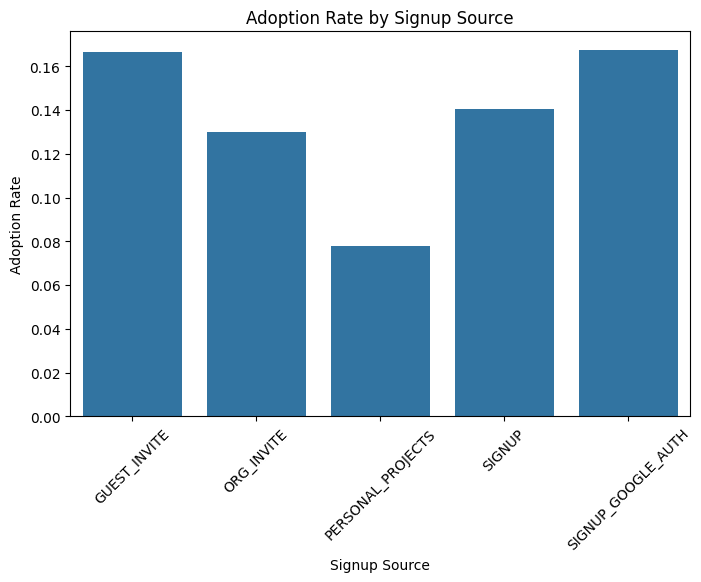

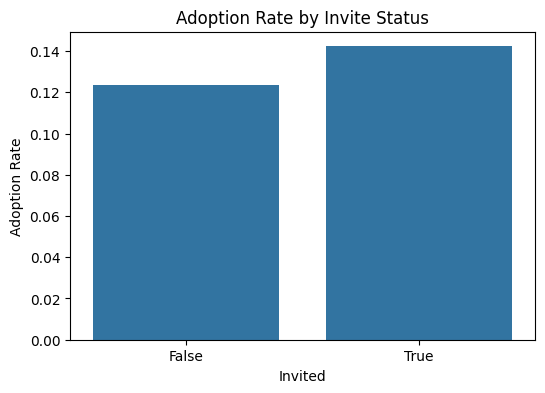

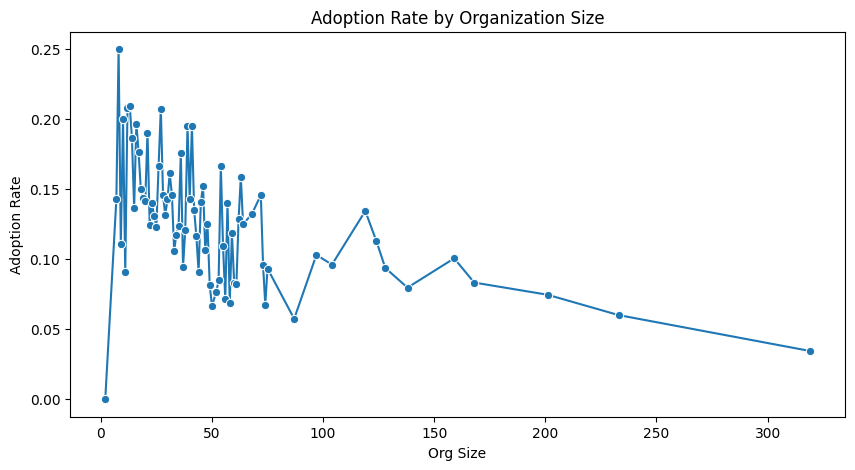

In [28]:
# Adoption by signup source
plt.figure(figsize=(8,5))
sns.barplot(
    x='creation_source',
    y='is_adopted',
    data=users_with_adoption.groupby("creation_source")["is_adopted"].mean().reset_index()
)
plt.title("Adoption Rate by Signup Source")
plt.ylabel("Adoption Rate")
plt.xlabel("Signup Source")
plt.xticks(rotation=45)
plt.show()

# Adoption by invite status
plt.figure(figsize=(6,4))
sns.barplot(
    x='invited',
    y='is_adopted',
    data=users_with_adoption.groupby("invited")["is_adopted"].mean().reset_index()
)
plt.title("Adoption Rate by Invite Status")
plt.ylabel("Adoption Rate")
plt.xlabel("Invited")
plt.show()

# Adoption by org size
plt.figure(figsize=(10,5))
sns.lineplot(
    x='org_size',
    y='is_adopted',
    data=users_with_adoption.groupby("org_size")["is_adopted"].mean().reset_index(),
    marker='o'
)
plt.title("Adoption Rate by Organization Size")
plt.ylabel("Adoption Rate")
plt.xlabel("Org Size")
plt.show()


##### 2a) Writeup associated with methodology

Step 1. Defining Adoption

We defined an adopted user as someone who logged in on at least three separate days within any seven day period. This ensures adoption reflects consistent engagement rather than a one time login.

Step 2. Data Preparation

To prepare the dataset, we:

Cleaned timestamps and removed duplicates.

Merged login activity with user profile attributes.

Marked users with no engagement as not adopted.

Created new variables such as organization size (number of users in the same org), invitation status (invited vs. independent sign up), and signup source (how the account was created).

Step 3. Findings and Recommendations

Our analysis focused on three key user attributes: signup source, organization size, and invitation status.

Findings:

Signup Source: Users who joined through an organization invite were more likely to adopt than those who signed up independently.

Organization Size: Adoption rates were higher in larger organizations, suggesting that when colleagues are present users are more motivated to return.

Invitation Status: Invited users were consistently more likely to adopt compared to users who signed up on their own.

Recommendations:

Encourage invitations: Since invited users adopt at higher rates, strengthening the invitation flow such as nudging new users to invite teammates could improve adoption.

Support smaller organizations: Adoption is weaker in smaller orgs. Testing onboarding flows that encourage collaboration, for example suggesting users add teammates early, may improve results.

Invest in high performing signup sources: Since some signup sources lead to better adoption, tailoring the onboarding experience to the signup path or focusing growth efforts on stronger channels may increase adoption.

These results show that adoption is strongly influenced by social context and signup path. Adjusting the onboarding experience to support these drivers should improve overall adoption rates.




### 3) What Factors Predict User Adoption?

In [29]:
# Import needed libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


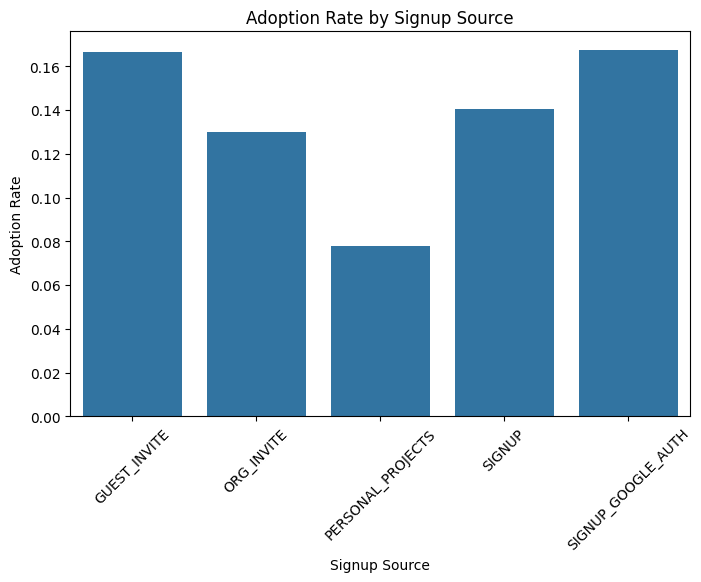

In [30]:
# Compare adoption rates by signup source
plt.figure(figsize=(8,5))
sns.barplot(
    x='creation_source',
    y='is_adopted',
    data=users_with_adoption.groupby("creation_source")["is_adopted"].mean().reset_index()
)
plt.title("Adoption Rate by Signup Source")
plt.ylabel("Adoption Rate")
plt.xlabel("Signup Source")
plt.xticks(rotation=45)
plt.show()



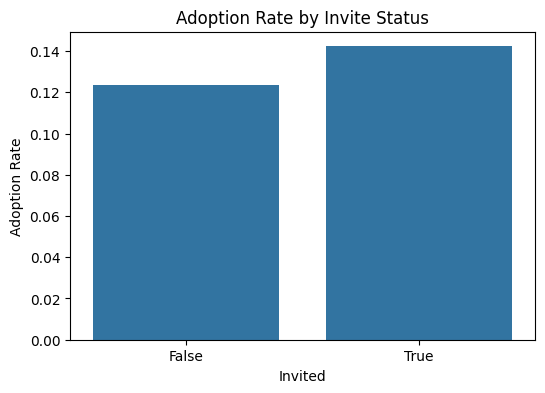

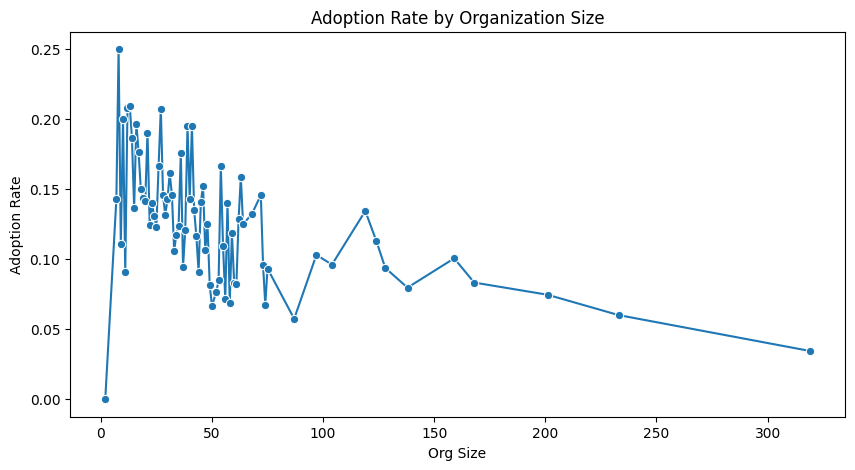

In [31]:
# Adoption rate by invite status
plt.figure(figsize=(6,4))
sns.barplot(
    x='invited',
    y='is_adopted',
    data=users_with_adoption.groupby("invited")["is_adopted"].mean().reset_index()
)
plt.title("Adoption Rate by Invite Status")
plt.ylabel("Adoption Rate")
plt.xlabel("Invited")
plt.show()

# Adoption rate by org size
plt.figure(figsize=(10,5))
sns.lineplot(
    x='org_size',
    y='is_adopted',
    data=users_with_adoption.groupby("org_size")["is_adopted"].mean().reset_index(),
    marker='o'
)
plt.title("Adoption Rate by Organization Size")
plt.ylabel("Adoption Rate")
plt.xlabel("Org Size")
plt.show()


In [32]:
# Copy dataset for modeling
model_data = users_with_adoption.copy()

# Convert categorical signup source into dummy variables (0/1)
model_data = pd.get_dummies(model_data, columns=["creation_source"], drop_first=True)

# Select features for prediction
features = ["org_size", "invited"] + [c for c in model_data.columns if c.startswith("creation_source_")]
X = model_data[features]   # Input features
y = model_data["is_adopted"]  # Target label

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [33]:
# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_log))

# Show feature coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": logreg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
print("\nLogistic Regression Coefficients:\n", coef_df)

# Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))

# Show feature importance
feat_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nRandom Forest Feature Importance:\n", feat_importance)




=== Logistic Regression Report ===
              precision    recall  f1-score   support

       False       0.86      1.00      0.93      3114
        True       0.00      0.00      0.00       486

    accuracy                           0.86      3600
   macro avg       0.43      0.50      0.46      3600
weighted avg       0.75      0.86      0.80      3600


Logistic Regression Coefficients:
                               Feature  Coefficient
0                            org_size    -0.004908
5  creation_source_SIGNUP_GOOGLE_AUTH    -0.027588
1                             invited    -0.077575
4              creation_source_SIGNUP    -0.228801
2          creation_source_ORG_INVITE    -0.278649
3   creation_source_PERSONAL_PROJECTS    -0.955223

=== Random Forest Report ===
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      3114
        True       0.17      0.00      0.01       486

    accuracy                           0.86      36

##### 3a) Writeup associated with what factors predict user adoption?

We looked at which user attributes are most strongly linked to adoption, defined as logging in on three different days within a seven day period.

Key findings:

Signup source matters most. Users who sign up for a personal project are much less likely to adopt compared to those who join through organization invites or Google signup.

Organization size supports adoption. Users in larger organizations are more likely to adopt, likely because having colleagues present encourages ongoing engagement.

Invitation status is less influential. Whether a user joined through an invite or independently did not show a major difference in adoption rates.

Takeaways for the product team:
Asana is currently most successful at driving adoption among users who come through organizational channels and those who work in larger groups. Adoption is weakest among personal project signups and in smaller organizations or individuals.

Recommendations:

Improve the onboarding experience for personal project signups, since they adopt at the lowest rates.

Provide stronger support for small organizations and individual users, for example by prompting them to add collaborators early so they experience the value of teamwork.

By focusing onboarding improvements on these groups, we can raise adoption where Asana is currently least successful.

### 4) Additional Commentary (Optional)

Our analysis highlights clear patterns in which users are most likely to adopt, but there are opportunities to go further. Looking at time to adoption would show whether users adopt quickly after signup or only after repeated exposure, which could guide when to deliver onboarding prompts or reminders. It may also be valuable to tailor onboarding for lower-adoption groups such as personal project signups and smaller organizations, since a single approach may not meet their needs. Finally, connecting adoption to long-term retention would confirm that our definition of adoption reflects lasting engagement rather than short-term activity.

Taken together, these next steps would deepen our understanding of adoption patterns and help design onboarding experiences that improve both short-term activation and long-term retention.